<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snow_melting_research_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Snow Melting Prediction With LSTM**

## install required library

In [25]:
# !pip install -U keras-tuner
# !pip install keras==2.12.0
# !pip install keras-tcn

## import Library

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
# import keras_tuner as kt

# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Load Dataset

In [5]:

# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab Notebooks/dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)

df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


## Dataset Pre-processing

In [6]:
features = ['Date',"Q","SCA","T",'P']
# features = ["Q"]
df_snow_melting = df_snow_melting[features]

In [8]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)


In [9]:
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)

df_snow_melting

<ipython-input-9-164b30e8e586>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


,Date,Q,SCA,T,P
0,2001-01-01,2.69,345.815123,-4.169740,0.000000
1,2001-01-02,2.53,343.608727,-4.142604,0.000000
2,2001-01-03,2.53,341.437417,-5.148725,0.000000
3,2001-01-04,2.43,339.336277,-6.523695,0.031144
4,2001-01-05,2.53,337.340394,-6.860106,0.000000
...,...,...,...,...,...
4012,2012-12-26,2.91,228.615063,-5.651230,0.000000
4013,2012-12-27,2.91,219.264614,-5.501225,0.000000
4014,2012-12-28,3.03,210.043412,-5.526874,0.000000
4015,2012-12-29,2.97,201.080703,-5.107484,0.000000


## Data visualization in time series

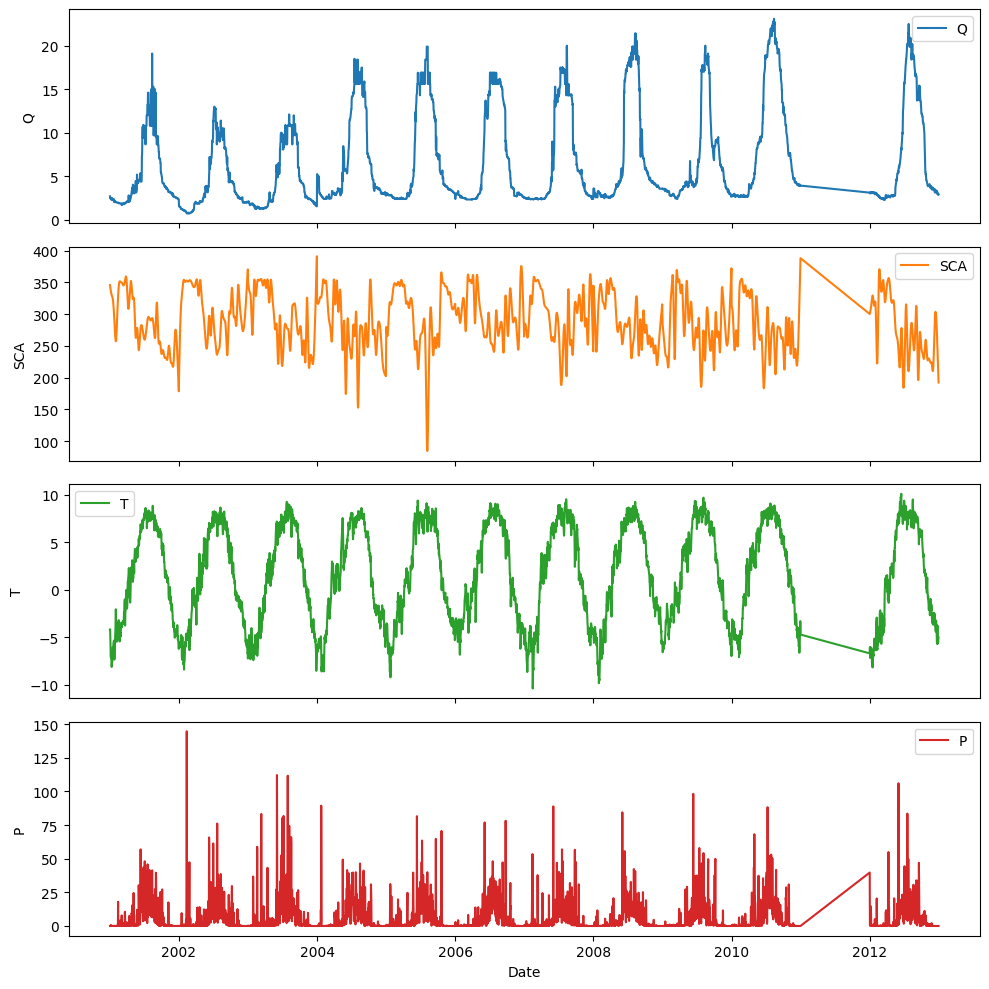

In [10]:
columns_to_plot = ['Q', 'SCA', 'T','P']

# Create subplots for each column
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 10), sharex=True)

for i, column in enumerate(columns_to_plot):
    axes[i].plot(df_snow_melting['Date'], df_snow_melting[column], label=column, color='C'+str(i))
    axes[i].set_ylabel(column)
    axes[i].legend()

# Set common x-label
axes[-1].set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [11]:
df_input = df_snow_melting[['Q','SCA', 'T']]


scaler = StandardScaler()

# Select the features you want to scale
features_to_scale = ['Q', 'SCA', 'T']

# Fit the scaler to the data and transform the selected features
df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


<ipython-input-11-69a01f0b435c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


In [12]:
df_input

,Q,SCA,T
0,-0.714983,1.306925,-1.170123
1,-0.744452,1.255788,-1.164703
2,-0.744452,1.205464,-1.365690
3,-0.762871,1.156767,-1.640360
4,-0.744452,1.110509,-1.707563
...,...,...,...
4012,-0.674462,-1.409374,-1.466072
4013,-0.674462,-1.626085,-1.436107
4014,-0.652360,-1.839801,-1.441230
4015,-0.663411,-2.047526,-1.357451


In [13]:
#[[[1],[2],[3],[4],[5]]][6]
#[[[2],[3],[4],[5],[6]]][7]
#[[[3],[4],[5],[6],[7]]][8]

def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(df_input,WINDOW_SIZE)

X.shape, y.shape

((4015, 2, 3), (4015,))

In [14]:
# X_train, y_train = X[:3285],y[:3285] # 9 year 80%
# X_val, y_val = X[3285:3648],y[3285:3648] # 363 days 10%
# X_test, y_test = X[3648:],y[3648:]  # 364 day 10%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((3285, 2, 3), (3285,), (363, 2, 3), (363,), (367, 2, 3), (367,))

In [15]:
num_features =  X_train.shape[2]


In [23]:
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=False, input_shape=(WINDOW_SIZE, num_features)))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
optimizer = Adamax(learning_rate=0.002,beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mae',RootMeanSquaredError()])


In [24]:
cp = ModelCheckpoint('model_64_layer_1/',save_best_only=True)
early_stopping = EarlyStopping(monitor="loss",
                               patience = 10,
                               mode = 'min')

model.fit(X_train,y_train,batch_size=32,epochs=50,callbacks=[cp,early_stopping])


Epoch 1/50
 81/101 [=======================>......] - ETA: 0s - loss: 0.2583 - mae: 0.3907 - root_mean_squared_error: 0.5082

101/101 [==============================] - 1s 2ms/step - loss: 0.2195 - mae: 0.3529 - root_mean_squared_error: 0.4685
Epoch 2/50
 98/101 [============================>.] - ETA: 0s - loss: 0.0332 - mae: 0.1394 - root_mean_squared_error: 0.1823

101/101 [==============================] - 0s 2ms/step - loss: 0.0328 - mae: 0.1382 - root_mean_squared_error: 0.1811
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.0264 - mae: 0.1172 - root_mean_squared_error: 0.1625

101/101 [==============================] - 0s 2ms/step - loss: 0.0264 - mae: 0.1172 - root_mean_squared_error: 0.1625
Epoch 4/50
 93/101 [==========================>...] - ETA: 0s - loss: 0.0223 - mae: 0.1049 - root_mean_squared_error: 0.1494

101/101 [==============================] - 0s 2ms/step - loss: 0.0219 - mae: 0.1043 - root_mean_squared_error: 0.1481
Epoch 5/50
100/101 [============================>.] - ETA: 0s - loss: 0.0203 - mae: 0.0978 - root_mean_squared_error: 0.1426

101/101 [==============================] - 0s 2ms/step - loss: 0.0203 - mae: 0.0976 - root_mean_squared_error: 0.1424
Epoch 6/50
100/101 [============================>.] - ETA: 0s - loss: 0.0189 - mae: 0.0930 - root_mean_squared_error: 0.1375

101/101 [==============================] - 0s 2ms/step - loss: 0.0189 - mae: 0.0931 - root_mean_squared_error: 0.1375
Epoch 7/50
 79/101 [======================>.......] - ETA: 0s - loss: 0.0183 - mae: 0.0895 - root_mean_squared_error: 0.1352

101/101 [==============================] - 0s 2ms/step - loss: 0.0177 - mae: 0.0886 - root_mean_squared_error: 0.1332
Epoch 8/50
 98/101 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0872 - root_mean_squared_error: 0.1326

101/101 [==============================] - 0s 2ms/step - loss: 0.0175 - mae: 0.0871 - root_mean_squared_error: 0.1324
Epoch 9/50
 92/101 [==========================>...] - ETA: 0s - loss: 0.0175 - mae: 0.0878 - root_mean_squared_error: 0.1325

101/101 [==============================] - 0s 2ms/step - loss: 0.0172 - mae: 0.0872 - root_mean_squared_error: 0.1313
Epoch 10/50
 95/101 [===========================>..] - ETA: 0s - loss: 0.0170 - mae: 0.0851 - root_mean_squared_error: 0.1303

101/101 [==============================] - 0s 3ms/step - loss: 0.0169 - mae: 0.0850 - root_mean_squared_error: 0.1301
Epoch 11/50
100/101 [============================>.] - ETA: 0s - loss: 0.0166 - mae: 0.0839 - root_mean_squared_error: 0.1289

101/101 [==============================] - 0s 3ms/step - loss: 0.0166 - mae: 0.0839 - root_mean_squared_error: 0.1288
Epoch 12/50
101/101 [==============================] - ETA: 0s - loss: 0.0161 - mae: 0.0832 - root_mean_squared_error: 0.1270

101/101 [==============================] - 0s 3ms/step - loss: 0.0161 - mae: 0.0832 - root_mean_squared_error: 0.1270
Epoch 13/50
100/101 [============================>.] - ETA: 0s - loss: 0.0155 - mae: 0.0806 - root_mean_squared_error: 0.1247

101/101 [==============================] - 0s 3ms/step - loss: 0.0155 - mae: 0.0806 - root_mean_squared_error: 0.1247
Epoch 14/50
 91/101 [==========================>...] - ETA: 0s - loss: 0.0145 - mae: 0.0769 - root_mean_squared_error: 0.1206

101/101 [==============================] - 0s 3ms/step - loss: 0.0145 - mae: 0.0769 - root_mean_squared_error: 0.1202
Epoch 15/50
 97/101 [===========================>..] - ETA: 0s - loss: 0.0151 - mae: 0.0789 - root_mean_squared_error: 0.1231

101/101 [==============================] - 0s 3ms/step - loss: 0.0152 - mae: 0.0790 - root_mean_squared_error: 0.1234
Epoch 16/50
 99/101 [============================>.] - ETA: 0s - loss: 0.0152 - mae: 0.0800 - root_mean_squared_error: 0.1234

101/101 [==============================] - 0s 3ms/step - loss: 0.0152 - mae: 0.0799 - root_mean_squared_error: 0.1231
Epoch 17/50
 87/101 [========================>.....] - ETA: 0s - loss: 0.0155 - mae: 0.0800 - root_mean_squared_error: 0.1246

101/101 [==============================] - 0s 3ms/step - loss: 0.0151 - mae: 0.0796 - root_mean_squared_error: 0.1228
Epoch 18/50
 98/101 [============================>.] - ETA: 0s - loss: 0.0141 - mae: 0.0768 - root_mean_squared_error: 0.1189

101/101 [==============================] - 0s 3ms/step - loss: 0.0141 - mae: 0.0768 - root_mean_squared_error: 0.1187
Epoch 19/50
 97/101 [===========================>..] - ETA: 0s - loss: 0.0145 - mae: 0.0777 - root_mean_squared_error: 0.1202

101/101 [==============================] - 0s 3ms/step - loss: 0.0143 - mae: 0.0771 - root_mean_squared_error: 0.1194
Epoch 20/50
 79/101 [======================>.......] - ETA: 0s - loss: 0.0144 - mae: 0.0759 - root_mean_squared_error: 0.1202

101/101 [==============================] - 0s 3ms/step - loss: 0.0147 - mae: 0.0764 - root_mean_squared_error: 0.1212
Epoch 21/50
 93/101 [==========================>...] - ETA: 0s - loss: 0.0138 - mae: 0.0745 - root_mean_squared_error: 0.1176

101/101 [==============================] - 0s 2ms/step - loss: 0.0138 - mae: 0.0745 - root_mean_squared_error: 0.1176
Epoch 22/50
 97/101 [===========================>..] - ETA: 0s - loss: 0.0143 - mae: 0.0751 - root_mean_squared_error: 0.1197

101/101 [==============================] - 0s 2ms/step - loss: 0.0143 - mae: 0.0752 - root_mean_squared_error: 0.1194
Epoch 23/50
 87/101 [========================>.....] - ETA: 0s - loss: 0.0138 - mae: 0.0751 - root_mean_squared_error: 0.1176

101/101 [==============================] - 0s 2ms/step - loss: 0.0139 - mae: 0.0751 - root_mean_squared_error: 0.1180
Epoch 24/50
 97/101 [===========================>..] - ETA: 0s - loss: 0.0140 - mae: 0.0739 - root_mean_squared_error: 0.1183

101/101 [==============================] - 0s 2ms/step - loss: 0.0138 - mae: 0.0733 - root_mean_squared_error: 0.1173
Epoch 25/50
 80/101 [======================>.......] - ETA: 0s - loss: 0.0140 - mae: 0.0765 - root_mean_squared_error: 0.1185

101/101 [==============================] - 0s 2ms/step - loss: 0.0146 - mae: 0.0768 - root_mean_squared_error: 0.1209
Epoch 26/50
 79/101 [======================>.......] - ETA: 0s - loss: 0.0137 - mae: 0.0738 - root_mean_squared_error: 0.1172

101/101 [==============================] - 0s 2ms/step - loss: 0.0135 - mae: 0.0732 - root_mean_squared_error: 0.1160
Epoch 27/50
 91/101 [==========================>...] - ETA: 0s - loss: 0.0138 - mae: 0.0738 - root_mean_squared_error: 0.1174

101/101 [==============================] - 0s 2ms/step - loss: 0.0134 - mae: 0.0734 - root_mean_squared_error: 0.1157
Epoch 28/50
100/101 [============================>.] - ETA: 0s - loss: 0.0125 - mae: 0.0702 - root_mean_squared_error: 0.1117

101/101 [==============================] - 0s 2ms/step - loss: 0.0125 - mae: 0.0702 - root_mean_squared_error: 0.1117
Epoch 29/50
 97/101 [===========================>..] - ETA: 0s - loss: 0.0140 - mae: 0.0721 - root_mean_squared_error: 0.1184

101/101 [==============================] - 0s 2ms/step - loss: 0.0140 - mae: 0.0722 - root_mean_squared_error: 0.1181
Epoch 30/50
 96/101 [===========================>..] - ETA: 0s - loss: 0.0127 - mae: 0.0707 - root_mean_squared_error: 0.1129

101/101 [==============================] - 0s 2ms/step - loss: 0.0128 - mae: 0.0710 - root_mean_squared_error: 0.1132
Epoch 31/50
 93/101 [==========================>...] - ETA: 0s - loss: 0.0131 - mae: 0.0720 - root_mean_squared_error: 0.1146

101/101 [==============================] - 0s 2ms/step - loss: 0.0130 - mae: 0.0720 - root_mean_squared_error: 0.1141
Epoch 32/50
101/101 [==============================] - ETA: 0s - loss: 0.0133 - mae: 0.0707 - root_mean_squared_error: 0.1155

101/101 [==============================] - 0s 2ms/step - loss: 0.0133 - mae: 0.0707 - root_mean_squared_error: 0.1155
Epoch 33/50
 98/101 [============================>.] - ETA: 0s - loss: 0.0131 - mae: 0.0715 - root_mean_squared_error: 0.1145

101/101 [==============================] - 0s 2ms/step - loss: 0.0131 - mae: 0.0715 - root_mean_squared_error: 0.1146
Epoch 34/50
 79/101 [======================>.......] - ETA: 0s - loss: 0.0128 - mae: 0.0703 - root_mean_squared_error: 0.1131

101/101 [==============================] - 0s 2ms/step - loss: 0.0126 - mae: 0.0703 - root_mean_squared_error: 0.1124
Epoch 35/50
 97/101 [===========================>..] - ETA: 0s - loss: 0.0128 - mae: 0.0696 - root_mean_squared_error: 0.1130

101/101 [==============================] - 0s 2ms/step - loss: 0.0131 - mae: 0.0699 - root_mean_squared_error: 0.1143
Epoch 36/50
 92/101 [==========================>...] - ETA: 0s - loss: 0.0124 - mae: 0.0692 - root_mean_squared_error: 0.1111

101/101 [==============================] - 0s 2ms/step - loss: 0.0126 - mae: 0.0698 - root_mean_squared_error: 0.1123
Epoch 37/50
 99/101 [============================>.] - ETA: 0s - loss: 0.0126 - mae: 0.0692 - root_mean_squared_error: 0.1123

101/101 [==============================] - 0s 2ms/step - loss: 0.0126 - mae: 0.0692 - root_mean_squared_error: 0.1122
Epoch 38/50
 94/101 [==========================>...] - ETA: 0s - loss: 0.0133 - mae: 0.0704 - root_mean_squared_error: 0.1155

101/101 [==============================] - 0s 2ms/step - loss: 0.0131 - mae: 0.0699 - root_mean_squared_error: 0.1143


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model_tensformer/')

# Model Evaulation

101/101 [==============================] - 0s 1ms/step
MAE: 0.048349440224642326
RMSE: 0.09415954283817568
R-squared (R2): 0.9911250161112843


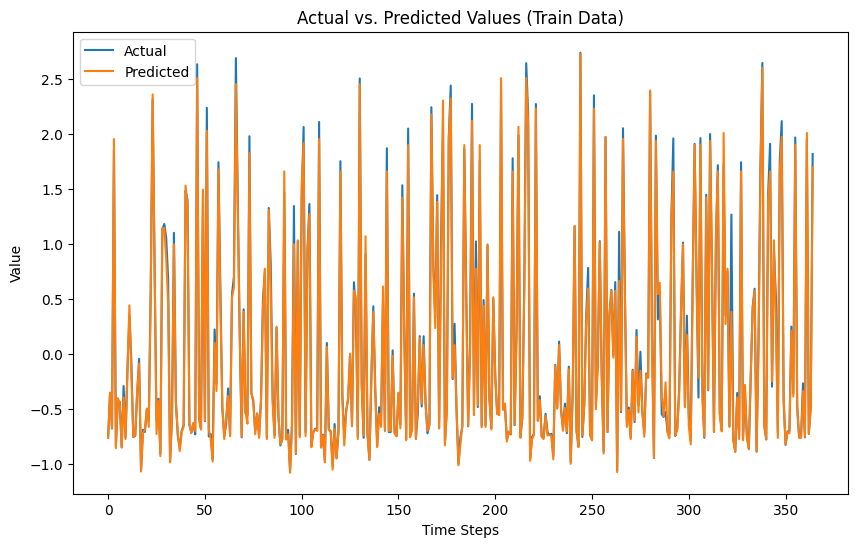

In [25]:

train_predictions = model.predict(X_train).flatten()
# train_predictions.shape
train_result = pd.DataFrame(data={"Train Predictions":train_predictions,"Actuals":y_train})
# Calculate MAE
mae = mean_absolute_error(y_train, train_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

# Calculate R2
r2 = r2_score(y_train, train_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)



plt.figure(figsize=(10, 6))
plt.plot(train_result['Train Predictions'][0:365], label='Actual')
plt.plot(train_result['Actuals'][0:365], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Train Data)')
plt.legend()
plt.show()

12/12 [==============================] - 0s 5ms/step
MAE: 0.11013540297129568
RMSE: 0.13503236110474148
R-squared (R2): 0.8070452263867937


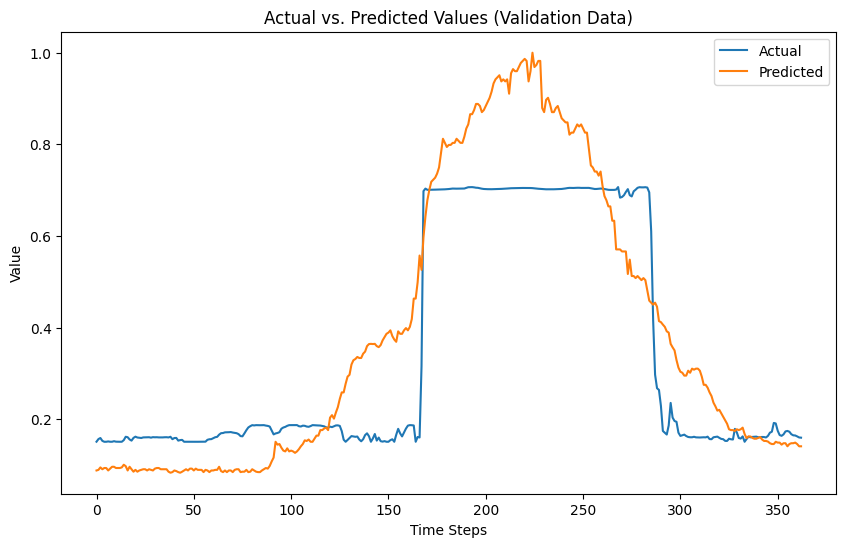

In [ ]:
val_predictions = model.predict(X_val).flatten()


# Calculate MAE
mae = mean_absolute_error(y_val, val_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Calculate R2
r2 = r2_score(y_val, val_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


val_result = pd.DataFrame(data={"val Predictions":val_predictions,"Actuals":y_val})


plt.figure(figsize=(10, 6))
plt.plot(val_result['val Predictions'], label='Actual')
plt.plot(val_result['Actuals'], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Validation Data)')
plt.legend()
plt.show()

26/26 [==============================] - 0s 1ms/step
MAE: 0.05143158317768289
RMSE: 0.11047277214201262
R-squared (R2): 0.9878526713156902


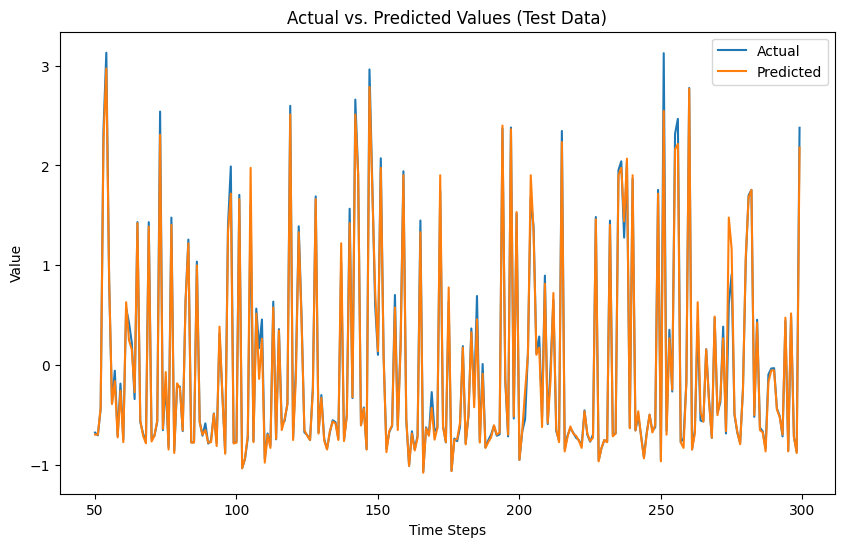

In [26]:
test_predictions = model.predict(X_test).flatten()

# Calculate MAE
mae = mean_absolute_error(y_test, test_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Calculate R2
r2 = r2_score(y_test, test_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


test_result = pd.DataFrame(data={"test Predictions":test_predictions,"Actuals":y_test})

plt.figure(figsize=(10, 6))
plt.plot(test_result['test Predictions'][50:300], label='Actual')
plt.plot(test_result['Actuals'][50:300], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()

# Hyperparameter Tuning

# find optimizers

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(6,3)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))

    optimizer = hp.Choice('optimizer', values = ["sgd","rmsprop","adam","adadelta","adagrad","adamax","adam"])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model


In [ ]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_loss',
                         max_trials=10)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 6 Complete [00h 00m 08s]
val_loss: 1.6287680864334106

Best val_loss So Far: 1.3862440586090088
Total elapsed time: 00h 01m 02s


In [ ]:
tuner.get_best_hyperparameters()[0].values


{'optimizer': 'sgd'}

In [ ]:
!rm -r /content/untitled_project

## Number of hidden units

In [ ]:
def build_model(hp):
    model = Sequential()

    units = hp.Int('units',min_value = 1,max_value = 128,step=5)

    model.add(LSTM(units=units, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = hp.Choice('optimizer', values = ["sgd","rmsprop","adam","adadelta","adagrad","adamax","adam"])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [ ]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 100 Complete [00h 00m 05s]
val_mae: 6.208195686340332

Best val_mae So Far: 1.8050360679626465
Total elapsed time: 00h 09m 47s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'units': 36, 'optimizer': 'sgd'}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                5472      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5509 (21.52 KB)
Trainable params: 5509 (21.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
101/101 [==============================] - 2s 7ms/step - loss: 9.0709 - mae: 2.0290 - mse: 9.0709 - val_loss: 7.1922 - val_mae: 1.8182 - val_mse: 7.1922
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 8.8137 - mae: 2.0119 - mse: 8.8137 - val_

# learning rate

In [ ]:
def build_model(hp):
    model = Sequential()

    model.add(LSTM(36, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = SGD(learning_rate=hp.Float(name='lr', min_value=0.005, max_value=0.05, step=0.005),momentum=hp.Float(name='mom', min_value=0.0, max_value=0.9, step=0.1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [ ]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 89 Complete [00h 00m 05s]
val_mae: 1.743226170539856

Best val_mae So Far: 1.7157219648361206
Total elapsed time: 00h 07m 58s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'lr': 0.034999999999999996, 'mom': 0.5}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                5472      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5509 (21.52 KB)
Trainable params: 5509 (21.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
101/101 [==============================] - 3s 7ms/step - loss: 8.6616 - mae: 1.9773 - mse: 8.6616 - val_loss: 6.9002 - val_mae: 1.7289 - val_mse: 6.9002
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 8.7430 - mae: 1.9854 - mse: 8.7430 - val_

#number of layers

In [ ]:
def build_model(hp):
    model = Sequential()

    for i in range(hp.Int('num_layers',min_value=1,max_value=5)):
      model.add(LSTM(36, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = SGD(learning_rate=0.034999999999999996,momentum=0.5)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [ ]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 5 Complete [00h 00m 06s]
val_mae: 4.357283115386963

Best val_mae So Far: 4.258514881134033
Total elapsed time: 00h 00m 56s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 5}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 36)             5472      
                                                                 
 lstm_1 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_2 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_3 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_4 (LSTM)               (None, 2, 36)             10512     
                                                                 
 dropout (Dropout)           (None, 2, 36)             0         
                                                                 
 dense (Dense)               (None, 2, 1)              3

In [ ]:
def build_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)
    units = [hp.Int('units_' + str(i), min_value=32, max_value=128, step=32) for i in range(num_layers)]
    activations = [hp.Choice('activation_' + str(i), values=['relu', 'tanh']) for i in range(num_layers)]

    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Set return_sequences to True for all but the last layer
        model.add(LSTM(units[i], activation=activations[i], return_sequences=return_sequences, input_shape=(6, 3)))

    model.add(Dense(1, activation='linear'))

    optimizer = hp.Choice('optimizer', values=["sgd", "rmsprop", "adam", "adadelta", "adagrad", "adamax"])

    # Set the learning rate based on the optimizer choice
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model


In [ ]:
tuner  = kt.RandomSearch(build_model,
                         objective='val_loss',
                         max_trials=100,
                         directory="final_dir",
                         project_name = "snow_melt_research_work")

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 100 Complete [00h 00m 26s]
val_loss: 11.89901065826416

Best val_loss So Far: 3.8367700576782227
Total elapsed time: 00h 34m 00s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'units_0': 64,
 'activation_0': 'relu',
 'optimizer': 'rmsprop',
 'learning_rate': 0.0005118355272157859,
 'units_1': 96,
 'activation_1': 'relu',
 'units_2': 32,
 'activation_2': 'relu'}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 6, 96)             61824     
                                                                 
 lstm_2 (LSTM)               (None, 32)                16512     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 95777 (374.13 KB)
Trainable params: 95777 (374.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
cp = ModelCheckpoint('model1/',save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss",
                               patience = 10,
                               mode = 'min')

model.fit(X_train,y_train,batch_size=32,validation_data=(X_val,y_val),epochs=100,callbacks=[cp,early_stopping])

Epoch 1/100
103/103 [==============================] - 13s 80ms/step - loss: 6.8771 - mae: 1.7574 - mse: 6.8771 - val_loss: 7.5383 - val_mae: 1.9378 - val_mse: 7.5383
Epoch 2/100
103/103 [==============================] - 2s 22ms/step - loss: 6.7073 - mae: 1.7309 - mse: 6.7073 - val_loss: 10.4346 - val_mae: 2.2795 - val_mse: 10.4346
Epoch 3/100
103/103 [==============================] - 2s 19ms/step - loss: 6.1898 - mae: 1.6495 - mse: 6.1898 - val_loss: 9.6750 - val_mae: 2.2440 - val_mse: 9.6750
Epoch 4/100
103/103 [==============================] - 6s 60ms/step - loss: 6.2918 - mae: 1.6585 - mse: 6.2918 - val_loss: 6.0568 - val_mae: 1.7667 - val_mse: 6.0568
Epoch 5/100
103/103 [==============================] - 3s 29ms/step - loss: 6.0807 - mae: 1.6237 - mse: 6.0807 - val_loss: 6.7698 - val_mae: 1.9308 - val_mse: 6.7698
Epoch 6/100
103/103 [==============================] - 3s 29ms/step - loss: 5.8155 - mae: 1.5951 - mse: 5.8155 - val_loss: 6.7678 - val_mae: 1.9000 - val_mse: 6.7678
E

# Nested Cross Validation

In [49]:
X_train.shape

(3212, 2, 4)

In [27]:
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

# Define the Keras Sequential model
def create_lstm_model(LSTM_units,dropout_rate):
    model = Sequential()
    model.add(LSTM(LSTM_units, activation='relu', return_sequences=False, input_shape=(WINDOW_SIZE, num_features)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))

    optimizer = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'RootMeanSquaredError'])

    return model

# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter tuning
param_grid = {
    'LSTM_units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3],
    # Add other hyperparameters for tuning
}


best_param = {
                "Lstm_unit" : 0,
                "dropout_rate" : 0
              }

best_model = None
best_score = float('inf')  # Initialize with a high value
nested_scores = []
# Perform Nested Cross-Validation
for train_ix, test_ix in outer_cv.split(X):
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    for params in ParameterGrid(param_grid):
        # model = create_lstm_model(LSTM_units=params['LSTM_units'], dropout_rate=params['dropout_rate'])
        mse_scores = []

        # for train_ix_inner, val_ix in inner_cv.split(X_train):
        #     X_train_inner, X_val = X_train[train_ix_inner], X_train[val_ix]
        #     y_train_inner, y_val = y_train[train_ix_inner], y_train[val_ix]

        #     model.fit(X_train_inner, y_train_inner, epochs=50, batch_size=32, verbose=0)
        #     y_pred = model.predict(X_val)
        #     mse = mean_squared_error(y_val, y_pred)
        #     mse_scores.append(mse)

        # mean_mse = np.mean(mse_scores)

        # if mean_mse < best_score:
        #     best_param["Lstm_unit"] = params['LSTM_units']
        #     best_param["dropout_rate"] = params['dropout_rate']
        #     best_score = mean_mse
        #     best_model = model

    # Now that we have the best model, evaluate it on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    nested_scores.append({
        "MSE": mse,
        "R^2": r2,
        "RMSE": rmse,
        "MAE": mae
    })




26/26 [==============================] - 0s 2ms/step


In [28]:

# After the nested cross-validation, you can analyze and compare the results for different folds
for fold, scores in enumerate(nested_scores):
    print(f"Fold {fold + 1} - MSE: {scores['MSE']:.3f}, MAE: {scores['MAE']:.3f},RMSE: {scores['RMSE']:.3f}, R^2: {scores['R^2']:.3f}")

# Calculate overall statistics
all_mse = [scores['MSE'] for scores in nested_scores]
all_mae = [scores['MAE'] for scores in nested_scores]
all_rsme = [scores['RMSE'] for scores in nested_scores]
all_r2 = [scores['R^2'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")

Fold 1 - MSE: 0.012, MAE: 0.051,RMSE: 0.110, R^2: 0.988
Fold 2 - MSE: 0.009, MAE: 0.049,RMSE: 0.093, R^2: 0.991
Fold 3 - MSE: 0.009, MAE: 0.051,RMSE: 0.097, R^2: 0.990
Fold 4 - MSE: 0.010, MAE: 0.049,RMSE: 0.099, R^2: 0.991
Fold 5 - MSE: 0.008, MAE: 0.045,RMSE: 0.087, R^2: 0.992
Mean MSE: 0.010
Mean MAE: 0.049
Mean RMSE: 0.097
Mean R^2: 0.990


In [50]:
best_model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 128)               68096     
                                                                 
 dropout_52 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 1)                 129       
                                                                 
Total params: 68225 (266.50 KB)
Trainable params: 68225 (266.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
best_param

{'Lstm_unit': 128, 'dropout_rate': 0.1}

In [52]:
best_model.save('/content/drive/MyDrive/Colab Notebooks/model/LSTM_model_input4_64.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


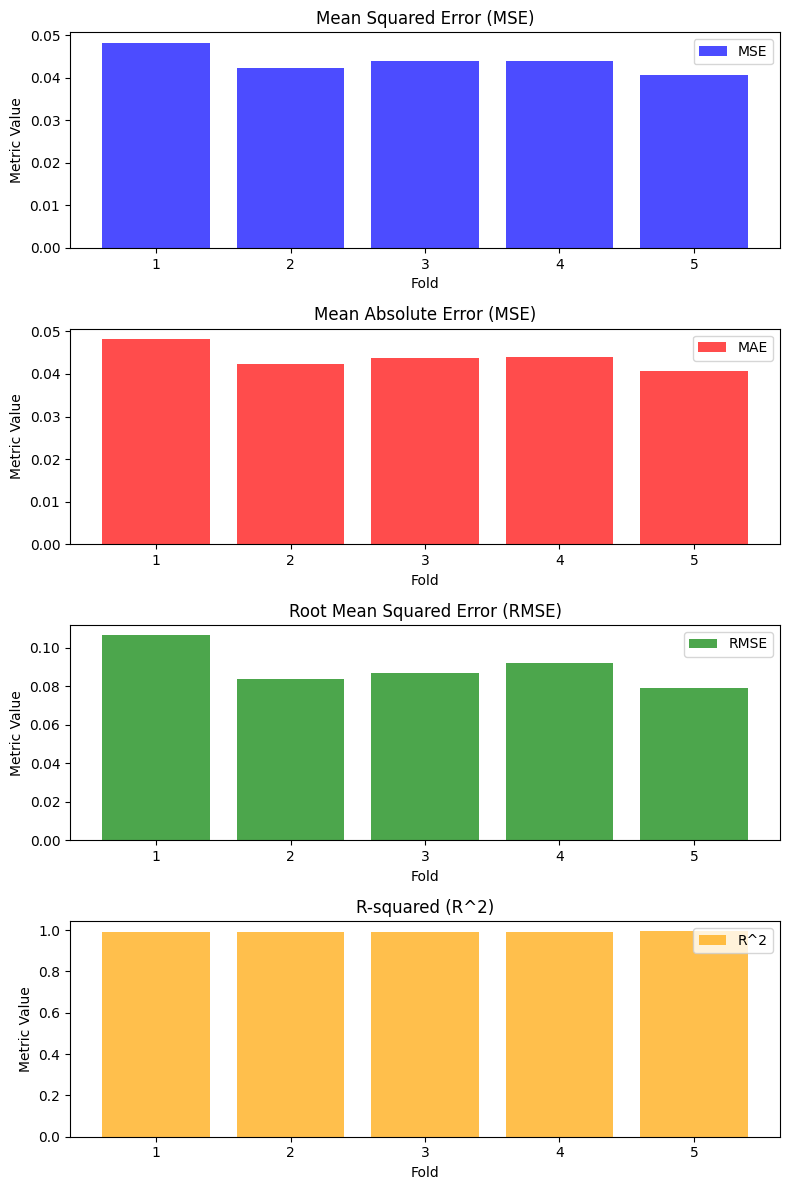

In [53]:
import matplotlib.pyplot as plt

# Extract the metrics from the nested_scores list
fold_numbers = range(1, len(nested_scores) + 1)
mse_values = [score['MSE'] for score in nested_scores]
mse_values = [score['MAE'] for score in nested_scores]
rmse_values = [score['RMSE'] for score in nested_scores]
r2_values = [score['R^2'] for score in nested_scores]

# Create subplots for each metric
fig, axs = plt.subplots(4, figsize=(8, 12))

# Create bar plots for each metric
axs[0].bar(fold_numbers, mse_values, color='blue', alpha=0.7, label='MSE')
axs[0].set_title('Mean Squared Error (MSE)')

axs[1].bar(fold_numbers, mse_values, color='red', alpha=0.7, label='MAE')
axs[1].set_title('Mean Absolute Error (MSE)')

axs[2].bar(fold_numbers, rmse_values, color='green', alpha=0.7, label='RMSE')
axs[2].set_title('Root Mean Squared Error (RMSE)')

axs[3].bar(fold_numbers, r2_values, color='orange', alpha=0.7, label='R^2')
axs[3].set_title('R-squared (R^2)')

# Add labels and legends
for ax in axs:
    ax.set_xlabel('Fold')
    ax.set_ylabel('Metric Value')
    ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
